# Proyecto ANN

In [5]:
from google.colab import files #Lectura del archivo
files.upload()

Saving beijing-air-quality.csv to beijing-air-quality.csv


{'beijing-air-quality.csv': b'date, pm25, pm10, o3, no2, so2, co\n2021/6/2, 57, 51, 39, 18, 1, 6\n2021/6/3, 78, 33, 36, 12, , 2\n2021/6/4, 18, , , , , \n2021/5/2, 47, 43, 41, 12, , 1\n2021/5/3, 51, 64, 61, 13, 2, 4\n2021/5/4, 104, 57, 38, 7, , 1\n2021/5/5, 56, 79, 49, 10, , 2\n2021/5/6, 86, 277, 40, 9, 1, 2\n2021/5/7, 168, 129, 40, 5, 1, 2\n2021/5/8, 120, 132, 37, 12, , 1\n2021/5/9, 122, 56, 53, 21, 1, 4\n2021/5/10, 91, 55, 51, 20, 1, 4\n2021/5/11, 81, 44, 72, 14, 1, 6\n2021/5/12, 83, 52, 72, 22, 1, 3\n2021/5/13, 62, 65, 55, 19, 3, 9\n2021/5/14, 146, 60, 43, 14, , 10\n2021/5/15, 115, 36, 30, 9, , 4\n2021/5/16, 45, 27, 38, 9, , 1\n2021/5/17, 16, 47, 49, 19, , 3\n2021/5/18, 54, 64, 58, 21, 1, 5\n2021/5/19, 82, 65, 93, 12, 2, 5\n2021/5/20, 104, 63, 76, 8, 1, 4\n2021/5/21, 115, 64, 101, 11, , 6\n2021/5/22, 113, 69, 107, 13, 1, 5\n2021/5/23, 91, 136, 34, 7, , 1\n2021/5/24, 116, 54, 33, 8, 1, 1\n2021/5/25, 62, 70, 66, 7, 1, 2\n2021/5/26, 67, 63, 47, 15, , 4\n2021/5/27, 63, 52, 36, 16, 1, 4\n

In [18]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [87]:
df = pd.read_csv("beijing-air-quality.csv")

In [88]:
print(df.head())

       date  pm25  pm10   o3  no2  so2  co
0  2021/6/2    57    51   39   18    1   6
1  2021/6/3    78    33   36   12        2
2  2021/6/4    18                         
3  2021/5/2    47    43   41   12        1
4  2021/5/3    51    64   61   13    2   4


In [89]:
print(df.shape) # Tamaño original
df.drop([' pm25',' pm10',   ' o3',  ' no2',  ' so2'], axis=1, inplace=True)
for col in df.columns:
    print(col)

for i in range(len(df[' co'])):
  if df[' co'][i] != ' ':
    df[' co'][i] = float(df[' co'][i])
  else:
    df.drop(i,axis=0,inplace=True)

print(type(df[' co'][16]))
print(df.shape) # Tamaño quitando valores inexistentes

df.head()

(2705, 7)
date
 co
<class 'float'>
(2695, 2)


,date,co
0,2021/6/2,6
1,2021/6/3,2
3,2021/5/2,1
4,2021/5/3,4
5,2021/5/4,1


In [90]:
df['date'] = pd.to_datetime(df['date'])
ind_df = df.set_index(['date'], drop=True)
ind_df.head()

,co
date,
2021-06-02,6
2021-06-03,2
2021-05-02,1
2021-05-03,4
2021-05-04,1


In [91]:
#Seleccionamos cuantos pasos queremos, se hará un ejemplo con 2,3 y 4 pasos, para esto ajustaremos los datos de tal forma que nos facilite el uso de estos
PASOS=6
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = ind_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
6,-0.870130,-0.974026,-1.000000,-0.922078,-1.000000,-0.974026,-0.974026
7,-0.974026,-1.000000,-0.922078,-1.000000,-0.974026,-0.974026,-0.974026
8,-1.000000,-0.922078,-1.000000,-0.974026,-0.974026,-0.974026,-1.000000
9,-0.922078,-1.000000,-0.974026,-0.974026,-0.974026,-1.000000,-0.922078
10,-1.000000,-0.974026,-0.974026,-0.974026,-1.000000,-0.922078,-0.922078


In [92]:
dfX=reframed[['var1(t-6)',	'var1(t-5)',	'var1(t-4)',	'var1(t-3)',	'var1(t-2)',	'var1(t-1)']]
dfY=reframed['var1(t)']

In [93]:
print("Total", int(dfX.shape[0]*1))
print("Entrenamiento", int(dfX.shape[0]*0.95))
print("Validacion", int(dfX.shape[0]*0.05))
partition=int(dfX.shape[0]*0.95)
dfXtrain = dfX.loc[:partition]
dfXtest = dfX.loc[partition:]
dfYtrain = dfY.loc[:partition]
dfYtest = dfY.loc[partition:]

Total 2689
Entrenamiento 2554
Validacion 134


In [94]:
scaler = MinMaxScaler()#StandardScaler
scaler.fit(dfXtrain.values)
train_sc = scaler.transform(dfXtrain.values)
test_sc = scaler.transform(dfXtest.values)

# Simple ANN for Time Series Forecasting | 6 Steps




A continuación implementamos con seis pasos:

In [103]:
nn_model = Sequential()
nn_model.add(Dense(100, input_dim=6, activation='relu',use_bias=True))
nn_model.add(Dense(32, activation='tanh'))
nn_model.add(Dense(16, activation='tanh'))
nn_model.add(Dense(8, activation='tanh'))
nn_model.add(Dense(4, activation='tanh'))
nn_model.add(Dense(2, activation='tanh'))
nn_model.add(Dense(1, activation='tanh'))
nn_model.add(Dense(1,use_bias=True))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.001)
# Se hace el entrenamiento con el conjunto de train
history = nn_model.fit(dfXtrain.values, dfYtrain.values, epochs=1000, batch_size=12, verbose=1, callbacks=[early_stop, reduce_lr], shuffle=False)

Epoch 1/1000
213/213 [==============================] - 1s 2ms/step - loss: 0.5661
Epoch 2/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.1538
Epoch 3/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0437
Epoch 4/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 5/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 6/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 7/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 8/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 9/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 10/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 11/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 12/1000
213/213 [==============================] - 0s 2ms/step - loss: 0.0125
E

In [104]:
y_pred_test_nn = nn_model.predict(dfXtest.values)
y_train_pred_nn = nn_model.predict(dfXtrain.values)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(dfYtrain.values, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(dfYtest.values, y_pred_test_nn)))

The R2 score on the Train set is:	0.603
The R2 score on the Test set is:	0.259


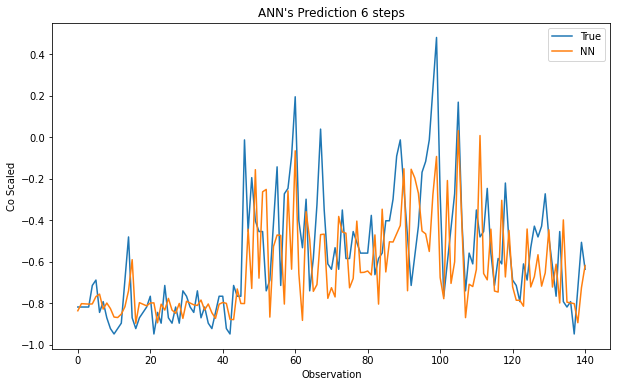

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(dfYtest.values, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction 6 steps")
plt.xlabel('Observation')
plt.ylabel('Co Scaled')
plt.legend()
plt.show();

#  ------------------------------------------------------------------------------